In [1]:
import pandas as pd
import numpy as np
import pyprind
import time

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

from surprise import accuracy
from surprise import Reader
from surprise.model_selection import train_test_split

from sklearn.neighbors.kde import KernelDensity

ModuleNotFoundError: No module named 'surprise'

In [ ]:
df = pd.read_csv('10-26 rating info.csv')
df.head()

In [ ]:
len(df)

In [31]:
sum(df.userid.value_counts()<5)

390

In [32]:
def random_undersample(df, target):
    new_df = pd.DataFrame()
    
    min_val = min(df[target].value_counts())
    for label in df[target].unique():
        undersample = df[df[target]==label].sample(min_val)
        new_df =  pd.concat([new_df, undersample])
    return new_df

def random_oversample(df, target):
    new_df = pd.DataFrame()
    
    max_val = max(df[target].value_counts())
    for label in df[target].unique():
        oversample = df[df[target]==label].sample(max_val, replace=True)
        new_df =  pd.concat([new_df, oversample])
    return new_df

In [33]:
osdf = random_oversample(df, 'rating')
usdf = random_undersample(df, 'rating')

In [39]:
osdf.rating.value_counts()

5    451319
4    451319
3    451319
2    451319
1    451319
Name: rating, dtype: int64

In [100]:
len(osdf)

2256595

In [54]:
# gr = Dataset.load_from_df(df, reader=Reader(rating_scale=(1, 5)))
# trainset, testset = train_test_split(gr, test_size=.25)

In [60]:
testdf = df.sample(int(0.25*len(df)))
testdf.head()

,userid,isbn,rating
518300,27332705,hash_0057cfce3577131894899333b023af97,4
744453,5142243,isbn_1415925992,4
1092311,8090035,hash_a932a79cf82f1c24fa8a0bc4ac12761f,4
239774,748925,isbn_0873585860,3
972604,1583037,isbn_0316154547,1


In [63]:
len(testdf)

300138

In [101]:
traindf = osdf.drop(testdf.index)

In [103]:
len(traindf)

1694451

In [102]:
trainset = Dataset.load_from_df(traindf, reader=Reader(rating_scale=(1, 5)))
testset = Dataset.load_from_df(testdf, reader=Reader(rating_scale=(1, 5)))

In [104]:
trainset, _ = train_test_split(trainset, test_size=1e-3)
_, testset = train_test_split(testset, test_size=1-1e-3)

In [90]:
# trainset = trainset.build_full_trainset()
# testset = testset.build_full_trainset()

In [105]:
algo = SVD(lr_all=0.005, reg_all = 0.0001, n_factors=200)

t0 = time.time()
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)
t1 = time.time()
print(t1-t0)

RMSE: 0.9894
167.00561237335205


In [106]:
algo2 = SVD(lr_all=0.005, reg_all = 0.01, n_factors=1)

t0 = time.time()
algo2.fit(trainset)
predictions2 = algo2.test(testset)

# Then compute RMSE
accuracy.rmse(predictions2)
t1 = time.time()
print(t1-t0)

RMSE: 1.0438
29.57666778564453


In [107]:
algo3 = SVD(lr_all=0.005, reg_all = 0.01, n_factors=5)

t0 = time.time()
algo3.fit(trainset)
predictions3 = algo3.test(testset)

# Then compute RMSE
accuracy.rmse(predictions3)
t1 = time.time()
print(t1-t0)

RMSE: 1.0390
34.380011796951294


In [84]:
# from surprise.model_selection import GridSearchCV

# param_grid = {'n_epochs': [10], 'lr_all': [0.002, 0.005, 0.01],
#               'reg_all': [0.0001, 0.01, 0.1, 1, 10],
#               'n_factors': [1, 5, 10, 50, 100, 200]}

# gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=1)

# gs.fit(trainset)

AttributeError: 'Trainset' object has no attribute 'raw_ratings'

In [132]:
progbar = pyprind.ProgBar(len(algo3.qi))

items = []

for i in range(len(algo3.qi)):
    items.append(([trainset.to_raw_iid(i), algo3.bi[i]] + list(algo3.qi[i])))
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [133]:
df_items = pd.DataFrame(items)
df_items.head()

,0,1,2,3,4,5,6
0,isbn_0061824550,0.200498,-0.111868,0.092222,0.048166,-0.212346,0.027795
1,hash_93e025ea062be974fd4061b919e1e6c6,0.222556,-0.208489,-0.277149,0.030910,0.024059,-0.171443
2,isbn_1563895269,-0.251048,-0.063259,0.084312,0.102085,0.038051,0.008810
3,isbn_0099476355,-0.375191,0.490031,0.603065,0.038427,-0.066043,-0.305796
4,isbn_1784702056,0.016006,-0.036683,0.042001,-0.127198,0.079484,0.005134


In [134]:
progbar = pyprind.ProgBar(len(algo3.pu))

users = []

for i in range(len(algo3.qi)):
    users.append(([trainset.to_raw_uid(i), algo3.bi[i]] + list(algo3.pu[i])))
    progbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


ValueError: 3831 is not a valid inner id.

In [139]:
df_users=pd.DataFrame(users)

In [140]:
df_users.head()

,0,1,2,3,4,5,6
0,2225246,0.200498,-0.137968,-0.786186,0.183056,-2.101229,-1.340910
1,11497566,0.222556,-0.906777,-0.272123,0.086635,0.085699,-0.017824
2,5741885,-0.251048,1.136032,-1.032216,-0.557767,-0.421448,-0.275501
3,3100006,-0.375191,-0.676718,-2.548110,1.160882,0.626145,1.259740
4,3167368,0.016006,-0.073013,0.381909,-1.046552,1.515379,1.704292


0.04035162925720215
0.14280942286787515
0.5305695584433884


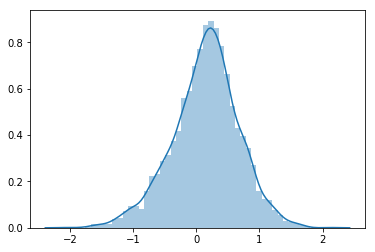

In [184]:
test_book = np.array(df_items.loc[1])
bi = test_book[1]
qi = test_book[2:]
ratings = []
t0 = time.time()
for row in df_users.itertuples():
    bu = row[2]
    pu = np.array(row[3:])
    rating = bi+ bu + np.dot(qi, pu)
    ratings.append(rating)
ratings = np.array(ratings)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(ratings.reshape(-1, 1))
t1 = time.time()
print(t1-t0)

test_book

kde.sample()

ratings[0:10]

kde.score_samples(np.array(0).reshape(1, -1))

print(np.mean(ratings))

print(np.std(ratings))

%matplotlib inline
import seaborn as sns
sns.distplot(ratings)




0.03650689125061035
-1.6173707535025323
0.8905437103884728


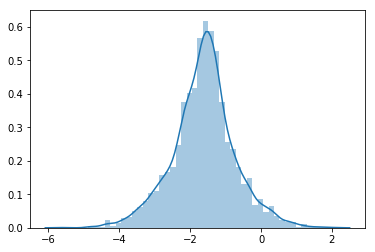

In [185]:
test_book = np.array(df_items.loc[100])
bi = test_book[1]
qi = test_book[2:]
ratings = []
t0 = time.time()
for row in df_users.itertuples():
    bu = row[2]
    pu = np.array(row[3:])
    rating = bi+ bu + np.dot(qi, pu)
    ratings.append(rating)
ratings = np.array(ratings)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(ratings.reshape(-1, 1))
t1 = time.time()
print(t1-t0)

test_book

kde.sample()

ratings[0:10]

kde.score_samples(np.array(0).reshape(1, -1))

print(np.mean(ratings))

print(np.std(ratings))

%matplotlib inline
import seaborn as sns
sns.distplot(ratings)




In [186]:
df_items.to_csv('10-26 book factor.csv')

In [187]:
df_users.to_csv('10-26 user factor.csv')

In [188]:
kde

KernelDensity(algorithm='auto', atol=0, bandwidth=0.2, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [189]:
kde.score(1)

ValueError: Expected 2D array, got scalar array instead:
array=1.0.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.